In [1]:
#Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import six
import sys
sys.modules['sklearn.externals.six'] = six
import warnings
warnings.filterwarnings(action="ignore",category=FutureWarning)

In [18]:
pd.options.display.float_format="{:,.3f}".format

In [3]:
#Loading data
df=pd.read_csv('data.csv').iloc[:,2:]
df.head()

,genre,summary
0,fantasy,Drowned Wednesday is the first Trustee among ...
1,fantasy,"As the book opens, Jason awakens on a school ..."
2,fantasy,Cugel is easily persuaded by the merchant Fia...
3,fantasy,The book opens with Herald-Mage Vanyel return...
4,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4657 entries, 0 to 4656
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   genre    4657 non-null   object
 1   summary  4657 non-null   object
dtypes: object(2)
memory usage: 72.9+ KB


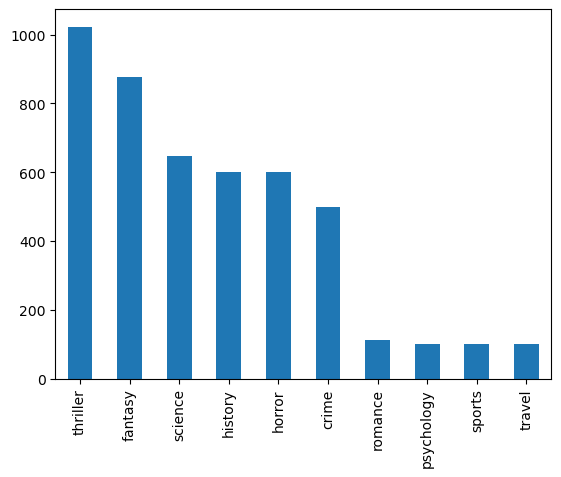

In [5]:
#Plotting the different kind of Genres
df['genre'].value_counts().plot(kind='bar');

## Creating an evaluation function for our model experiments

In [6]:
#Function to evaluate: accuracy,precision,recall,f1-score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  #Calculate model accuracy
  model_accuracy=accuracy_score(y_true,y_pred)

  #Calculate model precision,recall and f1-score using "weighted average"
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted',zero_division=0)
  model_results={'accuracy':model_accuracy.round(2)*100,
                 'precision':model_precision.round(2)*100,
                 "recall":model_recall.round(2)*100,
                 "f1":model_f1.round(2)*100}
              
  return model_results

## Defining train and test datasets

In [7]:
#Defining X and y
X=df.drop(columns=["genre"])
y=df[["genre"]]

In [8]:
#Splitting the data in train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, stratify=y,random_state=42)

## Make numeric labels (ML models require numeric labels)

In [9]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder()
train_labels_one_hot=one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1,1)).toarray()
test_labels_one_hot=one_hot_encoder.transform(y_test.to_numpy().reshape(-1,1)).toarray()

#Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Label encode labels

In [10]:
#Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(y_train.to_numpy().ravel())
test_labels_encoded=label_encoder.transform(y_test.to_numpy().ravel())

#Check what training labels look like
train_labels_encoded

array([8, 7, 1, ..., 6, 1, 6])

In [11]:
#Get class names and number of classes from LabelEncoder instance
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(10,
 array(['crime', 'fantasy', 'history', 'horror', 'psychology', 'romance',
        'science', 'sports', 'thriller', 'travel'], dtype=object))

# Starting a series of modelling experiments...

## Model 0: Testing the basic machine learning models, finding out the best and tuning it

In [19]:
#Importing the libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Preparing the models
models=[]
models.append(("Logistic Regression",LogisticRegression(solver="lbfgs",max_iter=10000,multi_class="multinomial")))
models.append(("MultinomialNB",MultinomialNB()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("Decision Tree",DecisionTreeClassifier()))
models.append(("XGB Classifier",XGBClassifier(objective="multi:softmax")))
models.append(("Cat Boost Classifier",CatBoostClassifier(n_estimators =100,learning_rate=0.1, max_depth=3, random_state=500,verbose=0)))
models.append(("LGBM Classifier",LGBMClassifier(max_depth = 3, learning_rate = 0.1, n_estimators = 10, objective='multiclass', seed=500,verbose=-100,force_row_wise=True,silent = True)))
models.append(("Random Forest",RandomForestClassifier()))
models.append(("Bagging Class",BaggingClassifier()))
models.append(("Extra trees",ExtraTreesClassifier()))
models.append(("Ada Boost",AdaBoostClassifier()))
models.append(("Gradient Boosting",GradientBoostingClassifier()))

#Evaluating each model in turn
results=[]
names=[]
scoring="accuracy"

for name, model in models:
    kfold=KFold(n_splits=10,shuffle=True)
    #Create a pipeline
    model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ('clf',model)
    ])
    cv_results=cross_val_score(model_0,X_train.values.ravel(),train_labels_encoded,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name} :{cv_results.mean()*100:,.2f}% ({cv_results.std()*100:.2f}%)")

Logistic Regression :61.68% (3.58%)
MultinomialNB :35.10% (2.12%)
KNN :47.84% (1.95%)
Decision Tree :42.59% (3.06%)
XGB Classifier :60.69% (2.14%)
Cat Boost Classifier :55.26% (2.63%)
LGBM Classifier :53.57% (2.60%)
Random Forest :55.26% (3.00%)
Bagging Class :50.14% (2.60%)
Extra trees :59.28% (2.20%)
Ada Boost :21.27% (4.55%)
Gradient Boosting :60.57% (2.05%)


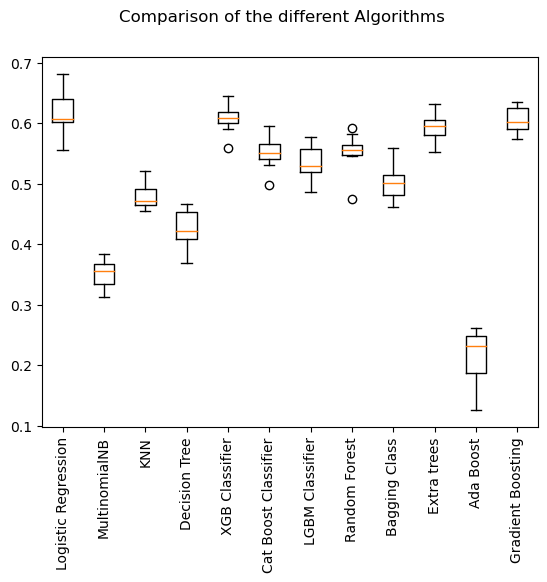

In [21]:
import matplotlib.pyplot as plt
fig=plt.figure()
fig.suptitle("Comparison of the different Algorithms")
ax=fig.add_subplot(111)
plt.rcParams["figure.figsize"]=[4,6]
plt.boxplot(results)
ax.set_xticklabels(names,rotation="vertical")
plt.show()

In [23]:
#Fine Tuning the best model

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np


#Build the steps
steps=[("tf-idf",TfidfVectorizer()),('logreg',LogisticRegression(solver="lbfgs",max_iter=10000,multi_class="multinomial"))]


pipeline=Pipeline(steps)

#Create the parameter space
parameters = {
    'logreg__C': np.linspace(0.001,1,20)
}


kfold=KFold(n_splits=5,shuffle=True)

grid_result=GridSearchCV(estimator=pipeline,param_grid=parameters,cv=kfold)

grid_result.fit(X_train.values.ravel(),train_labels_encoded) 

#Summarize_results

print("Best : %f using the params %s" % (grid_result.best_score_ , grid_result.best_params_))

means=grid_result.cv_results_["mean_test_score"]
stds=grid_result.cv_results_["std_test_score"]
params=grid_result.cv_results_["params"]


for mean,stdev,param in zip(means,stds,params):
    
  print("%f (%f) with %r" % (mean,stdev,param))

Best : 0.611541 using the params {'logreg__C': 1.0}
0.219696 (0.014014) with {'logreg__C': 0.001}
0.290572 (0.017468) with {'logreg__C': 0.05357894736842105}
0.369434 (0.020569) with {'logreg__C': 0.1061578947368421}
0.427429 (0.016402) with {'logreg__C': 0.15873684210526315}
0.465171 (0.017328) with {'logreg__C': 0.2113157894736842}
0.490335 (0.017712) with {'logreg__C': 0.26389473684210524}
0.509054 (0.016595) with {'logreg__C': 0.3164736842105263}
0.528080 (0.015783) with {'logreg__C': 0.36905263157894735}
0.544650 (0.013356) with {'logreg__C': 0.4216315789473684}
0.556310 (0.014554) with {'logreg__C': 0.47421052631578947}
0.567663 (0.013419) with {'logreg__C': 0.5267894736842105}
0.573187 (0.012470) with {'logreg__C': 0.5793684210526315}
0.580551 (0.013246) with {'logreg__C': 0.6319473684210526}
0.588222 (0.013412) with {'logreg__C': 0.6845263157894736}
0.592517 (0.010621) with {'logreg__C': 0.7371052631578947}
0.596200 (0.010604) with {'logreg__C': 0.7896842105263158}
0.601108 (0.

In [24]:
#Evaluating our best classic machine learning model
baseline_score=grid_result.score(X_test.values.ravel(),test_labels_encoded)
print(f"Our baseline model achieves an accuracy of:{baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of:64.02%


In [30]:
#Making predictions
baseline_preds=grid_result.predict(X_test.values.ravel())
baseline_preds[:10]

array([8, 8, 8, 8, 2, 1, 1, 8, 8, 8])

In [33]:
#Get baseline results

baseline_results=calculate_results(test_labels_encoded,baseline_preds)

baseline_results

{'accuracy': 64.0, 'precision': 65.0, 'recall': 64.0, 'f1': 61.0}

In [34]:
#Saving the fine_tuned model
from pickle import dump
dump(grid_result,open("model_0.pkl","wb"))

In [190]:
#Loading the model
import pickle
loaded_model = pickle.load(open('model_0.pkl', 'rb'))

In [191]:
#Making predictions

baseline_preds=loaded_model.predict(X_test.values.ravel())

#Get baseline results

baseline_results=calculate_results(test_labels_encoded,baseline_preds)

baseline_results

{'accuracy': 64.0, 'precision': 65.0, 'recall': 64.0, 'f1': 61.0}

## Model 1: Dense model using Sequential API + TF-IDF

In [56]:
import tensorflow as tf
from keras.layers import Dense
from keras import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer

In [199]:
tf=TfidfVectorizer()
tf.fit(X_train.values.ravel())
X_train_model_1=tf.transform(X_train.values.ravel()).toarray()
X_test_model_1=tf.transform(X_test.values.ravel()).toarray()

model_1=Sequential()
model_1.add(Dense(256,activation='relu'))
model_1.add(Dense(64,activation='relu'))
model_1.add(Dense(num_classes,activation='softmax'))
model_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
model_1.fit(X_train_model_1,train_labels_one_hot,epochs=3,validation_split=0.25)

Epoch 1/3
77/77 [==============================] - 20s 149ms/step - loss: 1.9556 - accuracy: 0.3163 - val_loss: 1.6090 - val_accuracy: 0.5583
Epoch 2/3
77/77 [==============================] - 11s 143ms/step - loss: 0.8563 - accuracy: 0.8245 - val_loss: 1.0746 - val_accuracy: 0.6564
Epoch 3/3
77/77 [==============================] - 11s 143ms/step - loss: 0.1713 - accuracy: 0.9804 - val_loss: 0.9504 - val_accuracy: 0.7104


In [52]:
#Evaluating our model
model_1.evaluate(X_test_model_1,test_labels_one_hot,verbose=0)

[1.000740885734558, 0.6866952776908875]

In [58]:
#Making predictions
model_1_pred_probs=model_1.predict(X_test_model_1)
model_1_pred_probs[:1]

44/44 [==============================] - 7s 40ms/step


array([[0.02842021, 0.05309341, 0.00954471, 0.71444225, 0.00491354,
        0.02241929, 0.04734169, 0.01482815, 0.09697691, 0.00801987]],
      dtype=float32)

In [59]:
#Convert pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([3, 0, 3, ..., 5, 3, 8], dtype=int64)>

In [60]:
#Calculate model_1_results
model_1_results=calculate_results(test_labels_encoded,
                                  model_1_preds)
model_1_results

{'accuracy': 69.0, 'precision': 72.0, 'recall': 69.0, 'f1': 69.0}

# Preparing our data (the text) for deeper Sequence Models

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [17]:
#How long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in X_train.values.ravel().tolist()]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

353.33292420988033

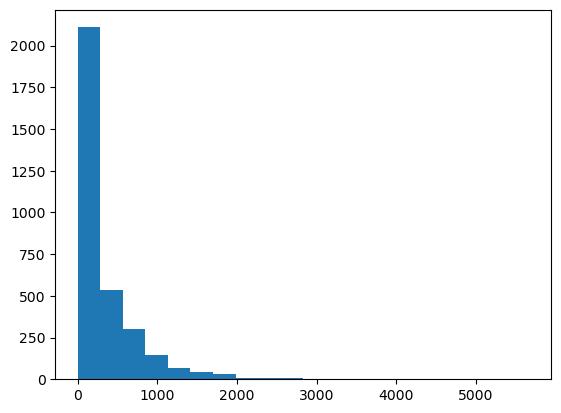

In [19]:
#What´s the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [20]:
#How long of a sentence length cover 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

1145

In [21]:
#Maximum sequence lenght in the training set
max(sent_lens)

5663

### Create a text vectorizer layer
-Tokenization:straight mapping from token to number can be modelled but quickly gets to big).

-Embedding:richer representation of relationships between tokens(can limit size + can be learned)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train.values.ravel())
len(vectorizer.get_feature_names_out()) #vectorizer.get_feature_names_out()

45952

In [28]:
#Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer=TextVectorization(max_tokens=45952, # number of words in vocabulary
                                  output_sequence_length=output_seq_len #desired output length of vectorized sequences 
                                  )

In [30]:
#Adapt text vectorizer to traning sentences
text_vectorizer.adapt(X_train.values.ravel())

In [32]:
#Test our text vectorize on random sentences
import random
target_sentence=random.choice(X_train.values.ravel())
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 In Odd We Trust serves as a prequel to the first Odd Thomas novel. The ghost of a young boy appears to Odd, and he embarks on a quest to bring justice to the boy's killer so that his ghost can move on. Odd's friend, the Chief of Police Wyatt Porter, shares some details of the case, and informs him that the boy's babysitter is the one that discovered the body. The babysitter turns out to be Sherry Sheldon, a childhood friend of Odd's girlfriend and soulmate, Stormy Llewellyn. Sherry relates that a stalker has been leaving her disturbing notes for several months, and believes this stalker may be the murderer. Odd and Stormy resolve to catch the stalker before he kills again. Odd asks the ghost of the little boy to help him find his killer, and Joey leads him to a street corner, where he sees a suspicious man. The man flees when Odd tries to address him. Odd gives chase, but loses his quarry when he trips over a lawn gnome. Four neighborhood children are believed to be targets, as 

In [33]:
#How many words in our training vocabulary
df_book_genre_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(df_book_genre_vocab)}")
print(f"Most common words in vocab:{df_book_genre_vocab[:5]}")
print(f"Least common words in vocab:{df_book_genre_vocab[-5:]}")

Number of words in vocab:45952
Most common words in vocab:['', '[UNK]', 'the', 'to', 'and']
Least common words in vocab:['hosea', 'hos', 'horwood', 'horwitzer', 'horthy']


In [34]:
#Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None, None),
 'dtype': 'string',
 'max_tokens': 45952,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1145,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [62]:
#Create token embedding layer
token_embed=layers.Embedding(input_dim=len(df_book_genre_vocab), #length of vocabulary
                             output_dim=128, #Note:different embedding sizes result in drastically different parameters to train
                             mask_zero=True, #use masking to handle variable sequence lengths (save space),
                             name='token_embedding')

In [63]:
#Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
  In Odd We Trust serves as a prequel to the first Odd Thomas novel. The ghost of a young boy appears to Odd, and he embarks on a quest to bring justice to the boy's killer so that his ghost can move on. Odd's friend, the Chief of Police Wyatt Porter, shares some details of the case, and informs him that the boy's babysitter is the one that discovered the body. The babysitter turns out to be Sherry Sheldon, a childhood friend of Odd's girlfriend and soulmate, Stormy Llewellyn. Sherry relates that a stalker has been leaving her disturbing notes for several months, and believes this stalker may be the murderer. Odd and Stormy resolve to catch the stalker before he kills again. Odd asks the ghost of the little boy to help him find his killer, and Joey leads him to a street corner, where he sees a suspicious man. The man flees when Odd tries to address him. Odd gives chase, but loses his quarry when he trips over a lawn gnome. Four neighborhood children are b

## Creating datasets (making sure our datasets loads as fast as possible)

In [64]:
#Turn our data into TensorFlow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((X_train.values.ravel(),train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test.values.ravel(),test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [65]:
#Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>

## Model 2 : Conv1D with token embeddings

In [67]:
#Create 1D conv model to process sequences
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) #vectorize text inputs
token_embeddings=token_embed(text_vectors) #create embedding
x=layers.Conv1D(64,kernel_size=5,padding='same',activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) #condense he outputs of our feature vector from conv layer
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(inputs,outputs)

#Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [68]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1145)             0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 1145, 128)        5881856   
                                                                 
 conv1d_1 (Conv1D)           (None, 1145, 64)          41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 10)                650 

In [72]:
#Fit the model
history_model_2=model_2.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=test_dataset,
                            validation_steps=int(0.1*len(test_dataset))) #only validate on 10% of the batches

Epoch 1/3
10/10 [==============================] - 5s 153ms/step - loss: 2.1155 - accuracy: 0.2250 - val_loss: 2.0340 - val_accuracy: 0.2188
Epoch 2/3
10/10 [==============================] - 2s 154ms/step - loss: 2.0690 - accuracy: 0.2000 - val_loss: 1.9858 - val_accuracy: 0.2188
Epoch 3/3
10/10 [==============================] - 2s 152ms/step - loss: 1.9964 - accuracy: 0.2594 - val_loss: 1.9806 - val_accuracy: 0.2188


In [73]:
#Evaluate on the whole validation dataset
model_2.evaluate(test_dataset,verbose=0)

[2.030951976776123, 0.22460657358169556]

In [75]:
#Make predictions (our model predicts prediction probability for each class)
model_2_pred_probs=model_2.predict(test_dataset)

44/44 [==============================] - 5s 39ms/step


In [76]:
#Convert pred probs to classes
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([8, 8, 8, ..., 8, 8, 8], dtype=int64)>

In [96]:
#Calculate model_2_results
model_2_results=calculate_results(test_labels_encoded,
                                  model_2_preds)
model_2_results

{'accuracy': 22.0, 'precision': 18.0, 'recall': 22.0, 'f1': 9.0}

# Recurrent Neural Networks (RNN's)

## Model 3: LSTM

In [115]:
#Create an LSTM model
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,) ,dtype='string')
x=text_vectorizer(inputs)
x=token_embed(x)
x=layers.LSTM(64,return_sequences=True)(x) #When you are stacking RNN cells together,you need to set return_sequences=True
x=layers.LSTM(64)(x)
x=layers.Dense(64,activation='relu')(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_3=tf.keras.Model(inputs,outputs,name='model_3_LSTM')

In [116]:
#Get a summary
model_3.summary()

Model: "model_3_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1145)             0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 1145, 128)        5881856   
                                                                 
 lstm_8 (LSTM)               (None, 1145, 64)          49408     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                      

In [117]:
#Compile the model
model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

#Fit model_3 to the data
history_model_3=model_3.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=test_dataset,
                            validation_steps=int(0.1*len(test_dataset)))

Epoch 1/3
10/10 [==============================] - 63s 4s/step - loss: 2.2626 - accuracy: 0.1906 - val_loss: 2.1300 - val_accuracy: 0.2188
Epoch 2/3
10/10 [==============================] - 41s 4s/step - loss: 2.0955 - accuracy: 0.2031 - val_loss: 1.9940 - val_accuracy: 0.1641
Epoch 3/3
10/10 [==============================] - 40s 4s/step - loss: 2.0044 - accuracy: 0.1813 - val_loss: 1.9962 - val_accuracy: 0.2188


In [118]:
#Evaluate on the whole test dataset
model_3.evaluate(test_dataset)

44/44 [==============================] - 52s 1s/step - loss: 2.0360 - accuracy: 0.2196


[2.0360045433044434, 0.2195994257926941]

In [94]:
#Make predictions (our model predicts prediction probability for each class)
model_3_pred_probs=model_3.predict(test_dataset)

44/44 [==============================] - 38s 644ms/step


In [95]:
#Convert pred probs to classes
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([8, 8, 8, ..., 8, 8, 8], dtype=int64)>

In [97]:
#Calculate model_3_results
model_3_results=calculate_results(test_labels_encoded,
                                  model_3_preds)
model_3_results

{'accuracy': 22.0, 'precision': 5.0, 'recall': 22.0, 'f1': 8.0}

## Model 4 : GRU

In [111]:
#Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,) , dtype=tf.string)
x=text_vectorizer(inputs)
x=token_embed(x)
x=layers.GRU(128,return_sequences=True)(x)
x=layers.GRU(64,return_sequences=True)(x)
x=layers.Dense(32,activation='relu')(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_4=tf.keras.Model(inputs,outputs,name='model_4_GRU')

In [112]:
model_4.summary()

Model: "model_4_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1145)             0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 1145, 128)        5881856   
                                                                 
 gru_17 (GRU)                (None, 1145, 128)         99072     
                                                                 
 gru_18 (GRU)                (None, 1145, 64)          37248     
                                                                 
 dense_39 (Dense)            (None, 1145, 32)          2080      
                                                       

In [113]:
#Compile the model
model_4.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

#Fit model_4 to the data
history_model_4=model_4.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=test_dataset,
                            validation_steps=int(0.1*len(test_dataset)))

Epoch 1/3
10/10 [==============================] - 61s 4s/step - loss: 2.2360 - accuracy: 0.2094 - val_loss: 2.1109 - val_accuracy: 0.2188
Epoch 2/3
10/10 [==============================] - 33s 3s/step - loss: 2.1150 - accuracy: 0.2000 - val_loss: 2.0379 - val_accuracy: 0.2188
Epoch 3/3
10/10 [==============================] - 33s 3s/step - loss: 2.0075 - accuracy: 0.2594 - val_loss: 2.0328 - val_accuracy: 0.2188


In [119]:
#Evaluate on the whole test dataset
model_4.evaluate(test_dataset)

44/44 [==============================] - 44s 932ms/step - loss: 2.0634 - accuracy: 0.2196


[2.0634143352508545, 0.2195994257926941]

In [120]:
#Make predictions (our model predicts prediction probability for each class)
model_4_pred_probs=model_4.predict(test_dataset)

44/44 [==============================] - 41s 719ms/step


In [121]:
#Convert pred probs to classes
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([8, 8, 8, ..., 8, 8, 8], dtype=int64)>

In [122]:
#Calculate model_4_results
model_4_results=calculate_results(test_labels_encoded,
                                  model_4_preds)
model_4_results

{'accuracy': 22.0, 'precision': 5.0, 'recall': 22.0, 'f1': 8.0}

## Model 5 : Bidirectional RNN

In [123]:
#Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype='string')
x=text_vectorizer(inputs)
x=token_embed(x)
x=layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)
x=layers.Bidirectional(layers.GRU(64))(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_5=tf.keras.Model(inputs,outputs,name='model_5_bidirectional')

In [124]:
model_5.summary()

Model: "model_5_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1145)             0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 1145, 128)        5881856   
                                                                 
 bidirectional (Bidirectiona  (None, 1145, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [125]:
#Compile the model
model_5.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

#Fit model_5 to the data
history_model_5=model_5.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=test_dataset,
                            validation_steps=int(0.1*len(test_dataset)))

Epoch 1/3
10/10 [==============================] - 112s 8s/step - loss: 2.2122 - accuracy: 0.1813 - val_loss: 2.0263 - val_accuracy: 0.2188
Epoch 2/3
10/10 [==============================] - 56s 6s/step - loss: 2.0197 - accuracy: 0.2344 - val_loss: 1.9719 - val_accuracy: 0.1641
Epoch 3/3
10/10 [==============================] - 55s 6s/step - loss: 1.9784 - accuracy: 0.2281 - val_loss: 1.9718 - val_accuracy: 0.2188


In [126]:
#Evaluate on the whole test dataset
model_5.evaluate(test_dataset)

44/44 [==============================] - 61s 1s/step - loss: 2.0077 - accuracy: 0.2239


[2.0077056884765625, 0.2238912731409073]

In [127]:
#Make predictions (our model predicts prediction probability for each class)
model_5_pred_probs=model_5.predict(test_dataset)

44/44 [==============================] - 67s 1s/step


In [128]:
#Convert pred probs to classes
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([8, 8, 8, ..., 8, 8, 8], dtype=int64)>

In [129]:
#Calculate model_5_results
model_5_results=calculate_results(test_labels_encoded,
                                  model_5_preds)
model_5_results

{'accuracy': 22.0, 'precision': 9.0, 'recall': 22.0, 'f1': 9.0}

## Model 6 : Feature Extraction with pretrained token embeddings

In [131]:
#Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name='universal_sentence_encoder')

In [132]:
#Test out the pretrained embedding on a random sentence
random_train_sentence=random.choice(X_train.values.ravel())
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
  Picnic at Hanging Rock centers around a trip by a party of girls from Appleyard College, a fictitious upper class private boarding school, who travel to Hanging Rock in the Mount Macedon area, Victoria, for a picnic on Valentine's Day 1900. The excursion ends in tragedy when three of the girls, and later one of their teachers, mysteriously vanish while climbing the rock. No reason for their disappearance is ever given, and one of the missing girls who is later found has no memory of what has happened to her companions. A fourth girl who also climbed the rock with the group is of little help in solving the mystery, having returned in hysterics for reasons she cannot explain. The disappearances provoke much local concern and international sensation with sexual molestation, abduction and murder being high on the list of possible outcomes. Several organized searches of the picnic grounds and the area surrounding the rock itself turn up nothing. Meanwhile the students, te

### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [133]:
#Define feature extraction model using TF Hub Layer
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence (512 long vector)
x=layers.Dense(128,activation="relu")(pretrained_embedding)
#Note: you could add more layers here if you wanted to
outputs=layers.Dense(num_classes,activation='softmax')(x) #create the output layer
model_6=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name='model_2_USE_feature_extractor')

#Compile the model
model_6.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [134]:
model_6.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_44 (Dense)            (None, 128)               65664     
                                                                 
 dense_45 (Dense)            (None, 10)                1290      
                                                                 
Total params: 256,864,778
Trainable params: 66,954
Non-trainable params: 256,797,824
_________________________________________________________________


In [142]:
#Fit model_6 to the data
history_model_6=model_6.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=test_dataset,
                            validation_steps=int(0.1*len(test_dataset)))

Epoch 1/3
10/10 [==============================] - 5s 224ms/step - loss: 1.1527 - accuracy: 0.6156 - val_loss: 1.2220 - val_accuracy: 0.5859
Epoch 2/3
10/10 [==============================] - 2s 186ms/step - loss: 1.1825 - accuracy: 0.6000 - val_loss: 1.1974 - val_accuracy: 0.6250
Epoch 3/3
10/10 [==============================] - 2s 213ms/step - loss: 1.1020 - accuracy: 0.6500 - val_loss: 1.1873 - val_accuracy: 0.6328


In [143]:
#Evaluate on the whole test dataset
model_6.evaluate(test_dataset)

44/44 [==============================] - 6s 135ms/step - loss: 1.1284 - accuracy: 0.6416


[1.1283636093139648, 0.6416308879852295]

In [144]:
#Make predictions (our model predicts prediction probability for each class)
model_6_pred_probs=model_6.predict(test_dataset)

44/44 [==============================] - 9s 134ms/step


In [147]:
#Convert pred probs to classes
model_6_preds=tf.argmax(model_6_pred_probs,axis=1)
model_6_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([3, 8, 3, ..., 1, 2, 8], dtype=int64)>

In [148]:
#Calculate model_6_results

model_6_results=calculate_results(test_labels_encoded,
                                  model_6_preds)
model_6_results

{'accuracy': 64.0, 'precision': 66.0, 'recall': 64.0, 'f1': 62.0}

## Model 7: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

### Creating a character-level tokenizer

In [150]:
X_train.values.ravel()[:1]

array([' As the story opens, the Austin family has settled in a New York City apartment after the events of The Moon by Night, and made some friends; blind young pianist Emily Gregory and Josiah "Dave" Davidson, who helps Emily get around. Emily is studying under the tutelage of the passionate, leonine Emmanuel Theotocopulous, better known as Mr. Theo. Canon Tallis, newly arrived at the Cathedral of Saint John the Divine after the events of The Arm of the Starfish, meets the Austin children and their friends just as they encounter an anachronistic Genie in a junk shop. Tallis advises and helps to protect the children as they are drawn into a mystery involving the Genie, a street gang called the Alphabats, and the local bishop\'s strange behavior. Dave is skeptical of the Genie, as is Suzy Austin, but the others are not sure. Centralized, single-minded activity on the part of the criminal Alphabats excites the suspicion of Canon Tallis, who interrogates Dave and Dr. Wallace Austin. Dr. 

In [151]:
#Making a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [153]:
#Text splitting non-character-level sequence into characters
random_train_sentence=random.choice(X_train.values.ravel())
split_chars(random_train_sentence)

'  E t h a n   F r o m e   i s   s e t   i n   a   f i c t i o n a l   N e w   E n g l a n d   t o w n   n a m e d   S t a r k f i e l d ,   w h e r e   a n   u n n a m e d   n a r r a t o r   t e l l s   t h e   s t o r y   o f   h i s   e n c o u n t e r   w i t h   E t h a n   F r o m e ,   a   m a n   w i t h   d r e a m s   a n d   d e s i r e s   t h a t   e n d   i n   a n   i r o n i c   t u r n   o f   e v e n t s .   T h e   n a r r a t o r   t e l l s   t h e   s t o r y   b a s e d   o n   a n   a c c o u n t   f r o m   o b s e r v a t i o n s   a t   F r o m e \' s   h o u s e   w h e n   h e   h a d   t o   s t a y   t h e r e   d u r i n g   a   w i n t e r   s t o r m .   T h e   n o v e l   i s   f r a m e d   b y   t h e   l i t e r a r y   d e v i c e   o f   a n   e x t e n d e d   f l a s h b a c k .   T h e   f i r s t   c h a p t e r   o p e n s   w i t h   a n   u n n a m e d   n a r r a t o r   w h o ,   w h i l e   s p e n d i n g   a   w i n t e r   i n   S 

In [154]:
#Split sequence-level data splits into character-level data splits
train_chars=[split_chars(sentence) for sentence in X_train.values.ravel()]
test_chars=[split_chars(sentence) for sentence in X_test.values.ravel()]
print(train_chars[:2])

['  A s   t h e   s t o r y   o p e n s ,   t h e   A u s t i n   f a m i l y   h a s   s e t t l e d   i n   a   N e w   Y o r k   C i t y   a p a r t m e n t   a f t e r   t h e   e v e n t s   o f   T h e   M o o n   b y   N i g h t ,   a n d   m a d e   s o m e   f r i e n d s ;   b l i n d   y o u n g   p i a n i s t   E m i l y   G r e g o r y   a n d   J o s i a h   " D a v e "   D a v i d s o n ,   w h o   h e l p s   E m i l y   g e t   a r o u n d .   E m i l y   i s   s t u d y i n g   u n d e r   t h e   t u t e l a g e   o f   t h e   p a s s i o n a t e ,   l e o n i n e   E m m a n u e l   T h e o t o c o p u l o u s ,   b e t t e r   k n o w n   a s   M r .   T h e o .   C a n o n   T a l l i s ,   n e w l y   a r r i v e d   a t   t h e   C a t h e d r a l   o f   S a i n t   J o h n   t h e   D i v i n e   a f t e r   t h e   e v e n t s   o f   T h e   A r m   o f   t h e   S t a r f i s h ,   m e e t s   t h e   A u s t i n   c h i l d r e n   a n d   t h e i r   f 

In [155]:
#What´s the average character length?
chars_lens=[len(sentence) for sentence in X_train.values.ravel()]
mean_char_len=np.mean(chars_lens)
mean_char_len

2073.7385701135318

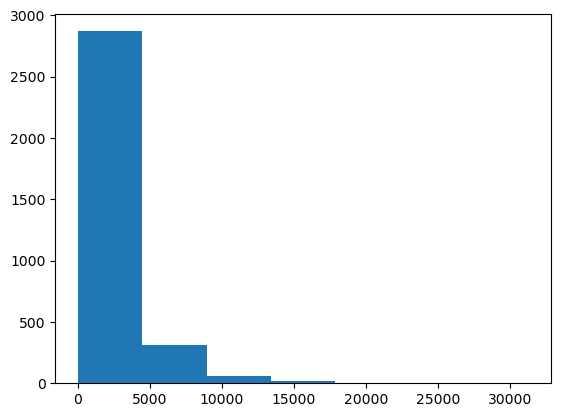

In [156]:
#Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(chars_lens,bins=7);

In [157]:
#Find wha character length covers 95% of sequences
output_seq_char_len=int(np.percentile(chars_lens,95))
output_seq_char_len

6602

In [158]:
#Get all keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [159]:
#Create char-level vectorizer instance
num_char_tokens=len(alphabet)+2 #add 2 for space and OOV token (OOV=out of vocab,'[UNK]')
char_vectorizer=TextVectorization(max_tokens=num_char_tokens,
                                  # standardize=None, #set standarization to "None" if you want to leave punctuation in
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [160]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [161]:
#Check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}") 
print(f"5 most common characters:{char_vocab[:5]}")
print(f"5 least common characters:{char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters:['', '[UNK]', 'e', 't', 'a']
5 least common characters:['ą', 'à', 'ć', 'ø', '\xa0']


In [162]:
#Test out our character vectorizer
random_train_chars=random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars:{len(vectorized_chars[0])}")

Charified text:
   T h e   s t o r y   b e g i n s   i n   T u s c a n y .   A   c a r p e n t e r   h a s   f o u n d   a   b l o c k   o f   p i n e w o o d   w h i c h   h e   p l a n s   t o   c a r v e   i n t o   a   l e g   f o r   h i s   t a b l e .   W h e n   h e   b e g i n s ,   h o w e v e r ,   t h e   l o g   s h o u t s   o u t ,   " D o n ' t   s t r i k e   m e   t o o   h a r d ! "   F r i g h t e n e d   b y   t h e   t a l k i n g   l o g ,   t h e   c a r p e n t e r ,   A n t o n i o   o r   M a s t e r   C h e r r y   a s   h e   i s   c a l l e d   d o e s   n o t   k n o w   w h a t   t o   d o   u n t i l   h i s   n e i g h b o r   G e p p e t t o ,   k n o w n   f o r   d i s l i k i n g   c h i l d r e n ,   d r o p s   b y   l o o k i n g   f o r   a   p i e c e   o f   w o o d   t o   b u i l d   a   m a r i o n e t t e .   S e e i n g   a   p e r f e c t   o p p o r t u n i t y ,   A n t o n i o   g i v e s   t h e   b l o c k   t o   G e p p e t t o .

### Creating a character-level embedding

In [163]:
#Create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab), #number of different characters
                            output_dim=25, #this is the size of the char embedding in the paper
                            mask_zero=True,
                            name='char_embed')

In [164]:
#Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text:
   T h e   s t o r y   b e g i n s   i n   T u s c a n y .   A   c a r p e n t e r   h a s   f o u n d   a   b l o c k   o f   p i n e w o o d   w h i c h   h e   p l a n s   t o   c a r v e   i n t o   a   l e g   f o r   h i s   t a b l e .   W h e n   h e   b e g i n s ,   h o w e v e r ,   t h e   l o g   s h o u t s   o u t ,   " D o n ' t   s t r i k e   m e   t o o   h a r d ! "   F r i g h t e n e d   b y   t h e   t a l k i n g   l o g ,   t h e   c a r p e n t e r ,   A n t o n i o   o r   M a s t e r   C h e r r y   a s   h e   i s   c a l l e d   d o e s   n o t   k n o w   w h a t   t o   d o   u n t i l   h i s   n e i g h b o r   G e p p e t t o ,   k n o w n   f o r   d i s l i k i n g   c h i l d r e n ,   d r o p s   b y   l o o k i n g   f o r   a   p i e c e   o f   w o o d   t o   b u i l d   a   m a r i o n e t t e .   S e e i n g   a   p e r f e c t   o p p o r t u n i t y ,   A n t o n i o   g i v e s   t h e   b l o c k   t o   G e p p e t t o .

In [177]:
#1. Set-up token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string , name='token_input')
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

#2. Set-up char inputs/model
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name='char_input')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)

#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat=layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                char_model.output])

#4. Create output layers - adding a Dropout layer
combined_dropout=layers.Dropout(0.1) (token_char_concat)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
output_layer=layers.Dense(num_classes,activation='softmax')(combined_dense)

#5. Construct model with char and token inputs
model_7=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name='model_7_token_and_char_embeddings')

In [178]:
#Get a summary of our model
model_7.summary()

Model: "model_7_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 6602)        0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

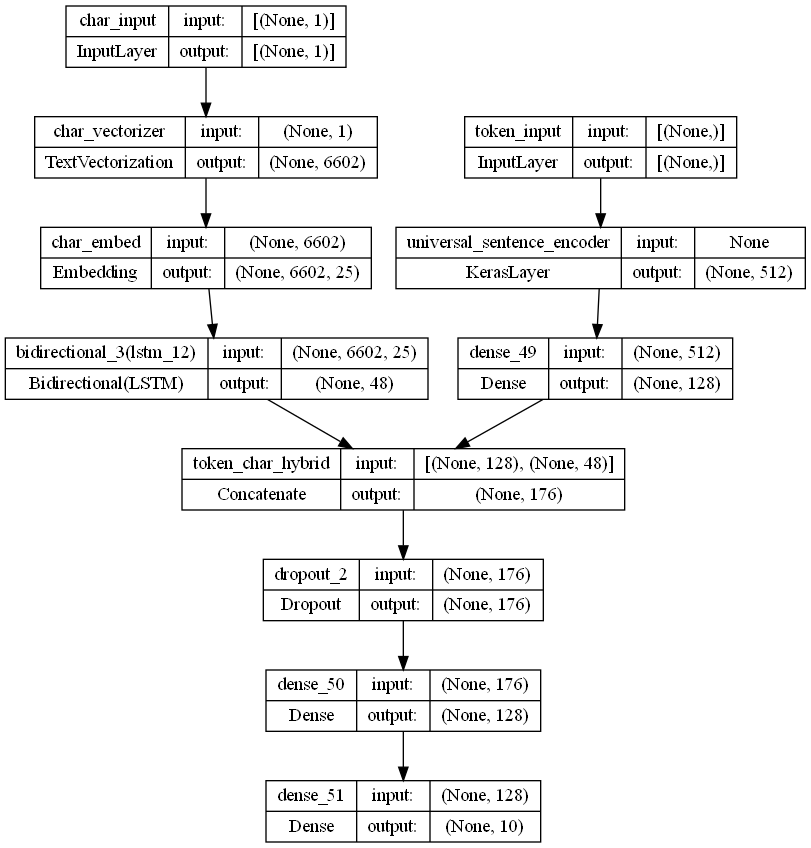

In [179]:
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_7,show_shapes=True)

In [180]:
#Compile token char model
model_7.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Combining token and character data into a tf.data.Dataset

In [169]:
# Combine chars and tokens into a dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((X_train.values.ravel(),train_chars)) #make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot) #make the labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

#Prefetch and batch train data
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [170]:
#Repeat the steps above in the for test data
test_char_token_data=tf.data.Dataset.from_tensor_slices((X_test.values.ravel(),test_chars)) #make data
test_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot) #make the labels
test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))
test_char_token_dataset=test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [171]:
#Check out our training and token embedding dataset
train_char_token_dataset,test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>)

In [181]:
#Fit the model on tokens and chars
model_7_history=model_7.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=test_char_token_dataset,
                            validation_steps=int(0.1*len(test_char_token_dataset)))

Epoch 1/3
10/10 [==============================] - 175s 15s/step - loss: 2.2441 - accuracy: 0.2062 - val_loss: 2.1395 - val_accuracy: 0.2188
Epoch 2/3
10/10 [==============================] - 140s 14s/step - loss: 2.0946 - accuracy: 0.2031 - val_loss: 1.9476 - val_accuracy: 0.2188
Epoch 3/3
10/10 [==============================] - 145s 15s/step - loss: 1.8842 - accuracy: 0.3063 - val_loss: 1.8476 - val_accuracy: 0.2969


In [182]:
#Evaluate on the whole validation dataset
model_7.evaluate(test_char_token_dataset)

44/44 [==============================] - 61s 1s/step - loss: 1.8674 - accuracy: 0.3262


[1.8674395084381104, 0.32618024945259094]

In [183]:
#Make predictions with character model only
model_7_pred_probs=model_7.predict(test_char_token_dataset)
model_7_pred_probs

44/44 [==============================] - 65s 1s/step


array([[0.12294263, 0.21330783, 0.0879248 , ..., 0.02020645, 0.28693545,
        0.02436505],
       [0.1205432 , 0.14535712, 0.11502643, ..., 0.02092022, 0.36370096,
        0.02303449],
       [0.12715945, 0.21269369, 0.09498918, ..., 0.02409657, 0.25856256,
        0.03015859],
       ...,
       [0.10127497, 0.22785395, 0.10371084, ..., 0.02273169, 0.27884603,
        0.02551082],
       [0.09710261, 0.24046269, 0.12978053, ..., 0.01513851, 0.2763492 ,
        0.01945724],
       [0.12584475, 0.14375089, 0.0856255 , ..., 0.01703597, 0.4096807 ,
        0.01838267]], dtype=float32)

In [185]:
#Convert predictions probabilities to class labels
model_7_preds=tf.argmax(model_7_pred_probs,axis=1)
model_7_preds

<tf.Tensor: shape=(1398,), dtype=int64, numpy=array([8, 8, 8, ..., 8, 8, 8], dtype=int64)>

In [186]:
#Calculate the results of token-char-hybrid model
model_7_results=calculate_results(y_true=test_labels_encoded,
                                  y_pred=model_7_preds)

model_7_results

{'accuracy': 33.0, 'precision': 18.0, 'recall': 33.0, 'f1': 21.0}

## Comparing the performance of each of our models

In [192]:
#Combining model results into a DataFrame
all_model_results=pd.DataFrame({'Model 0: Best Basic ML Model':baseline_results,
                                "Model 1: Dense model using Sequential API + TF-IDF ":model_1_results,
                                "Model 2: Conv1D with token embeddings":model_2_results,
                                "Model 3: LSTM":model_3_results,
                                "Model 4: GRU":model_4_results,
                                "Model 5: Bidirectional RNN":model_5_results,
                                "Model 6: Feature Extraction with pretrained token embeddings":model_6_results,
                                "Model 7: Pretrained token embeddings + characters embeddings":model_7_results})
 
all_model_results=all_model_results.T

all_model_results

,accuracy,precision,recall,f1
Model 0: Best Basic ML Model,64.000,65.000,64.000,61.000
Model 1: Dense model using Sequential API + TF-IDF,69.000,72.000,69.000,69.000
Model 2: Conv1D with token embeddings,22.000,18.000,22.000,9.000
Model 3: LSTM,22.000,5.000,22.000,8.000
Model 4: GRU,22.000,5.000,22.000,8.000
Model 5: Bidirectional RNN,22.000,9.000,22.000,9.000
Model 6: Feature Extraction with pretrained token embeddings,64.000,66.000,64.000,62.000
Model 7: Pretrained token embeddings + characters embeddings,33.000,18.000,33.000,21.000


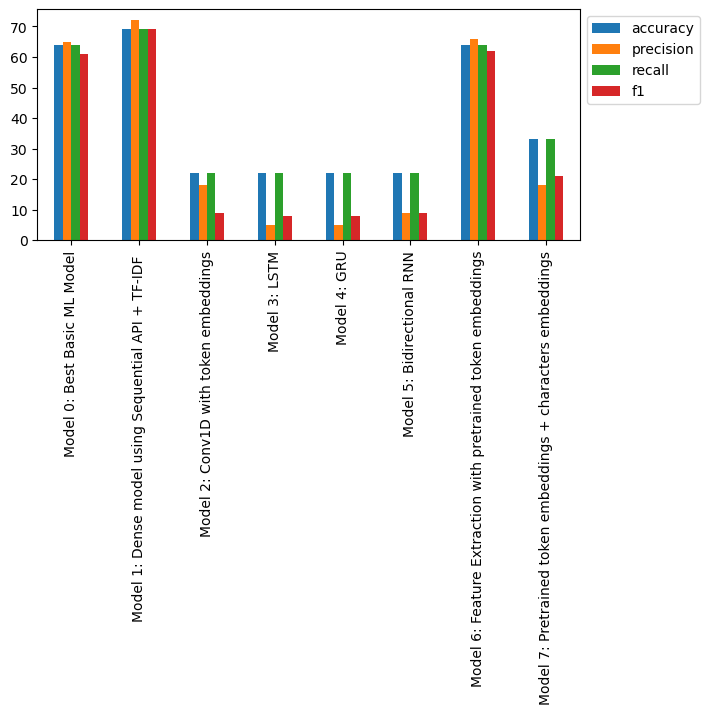

In [195]:
#Plot and compare all of the model results
all_model_results.plot(kind='bar',figsize=(7,3)).legend(bbox_to_anchor=(1,1));

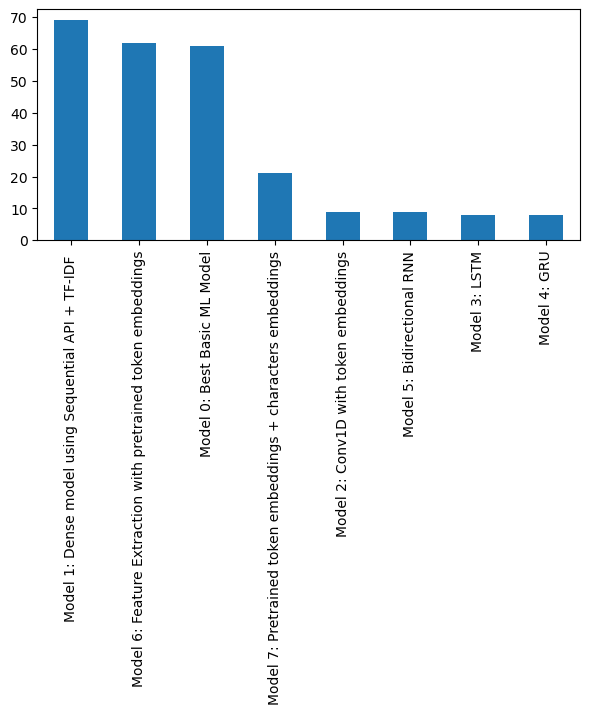

In [197]:
#Sort model results by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind='bar',figsize=(7,3));

## Finding the most wrong examples

In [207]:
#Making predictions with the best model (Model_1)
model_1_pred_probs=model_1.predict(X_test_model_1)
model_1_preds=np.argmax(model_1_pred_probs,axis=1)
model_1_preds[:10]

44/44 [==============================] - 3s 34ms/step


array([3, 0, 3, 8, 3, 1, 1, 8, 8, 8], dtype=int64)

In [210]:
#Create a DataFrame with test sentences, validation labels and best performing model prediction labels + probabilities
test_df=pd.DataFrame({"text":X_test.values.ravel(),
                     "target":test_labels_encoded,
                     "pred":model_1_preds,
                     "pred_prob":np.max(model_1_pred_probs)


})

test_df.head()


,text,target,pred,pred_prob
0,"Taking place in a city of the future, a group...",6,3,0.999
1,This fictional story is set during The Great ...,8,0,0.999
2,Cassandra Khaw's Nothing But Blackened Teeth i...,3,3,0.999
3,"The President is dead—and the weight, literall...",8,8,0.999
4,"On a May afternoon in 1943, an Army Air Forces...",2,3,0.999


In [212]:
#Find the wrong predictions and sort by prediction probabilities
most_wrong=test_df[test_df["target"]!=test_df["pred"]].sort_values("pred_prob",ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
0,"Taking place in a city of the future, a group...",6,3,0.999
978,It's been eighteen months since the Raxter Sch...,3,1,0.999
1005,"An aging death-metal rock god, Judas Coyne, is...",8,3,0.999
1004,The story begins with a slave driver attempti...,1,8,0.999
1000,"The year is 1945. Claire Randall, a former com...",5,2,0.999
997,Vagabonding is about taking time off from your...,9,1,0.999
993,There is an alternate cover edition for ISBN13...,5,1,0.999
992,"""I believe there is another man inside every m...",3,8,0.999
989,The Fear begins 5 days before Small Sam and T...,8,3,0.999
987,"After living in Britain for two decades, Bill ...",9,2,0.999


In [214]:
for row in most_wrong[:10].itertuples():
  _,text,target,pred,pred_prob=row
  print(f"Target:{target}, Pred:{pred}, Prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target:6, Pred:3, Prob:0.9992467761039734
Text:
 Taking place in a city of the future, a group of bored wealthy women begin dabbling in ancient satanic rituals, unaware that their rites are actually working. The beast of pure evil, Golem100, is raised each time the group practices their ritual, embarking on a rampage of rape, torture and murder. The demon is tracked through the physical and spirit worlds by Gretchen Nunn, a master of psychodynamics, Blaise Shima, a brilliant and famous chemist, and a clever local police officer, Subadar Ind'dni.

----

Target:3, Pred:1, Prob:0.9992467761039734
Text:
It's been eighteen months since the Raxter School for Girls was put under quarantine. Since the Tox hit and pulled Hetty's life out from under her.

It started slow. First the teachers died one by one. Then it began to infect the students, turning their bodies strange and foreign. Now, cut off from the rest of the world and left to fend for themselves on their island home, the girls don't d